In [70]:
%reload_ext autoreload
%autoreload 2


In [97]:
#!/usr/bin/env python
# -*- coding:utf-8 -*-
#
# Created: 03/2022
# Author: Carmelo Mordini <cmordini@phys.ethz.ch>

import cvxpy as cx
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sg

from pytrans import objectives as obj
from pytrans.solver import solver, init_waveform

from models.surface_trap.filter import trap_filter
from pytrans.filter import TrapFilterTransform


n_samples = 256
_t = np.arange(n_samples)
voltage0 = sg.sawtooth(2 * np.pi * 4 * _t / _t.max(), width=0.5)
n_pad = 30
filter_transform = TrapFilterTransform(trap_filter)

waveform0 = init_waveform(n_samples, 1)
waveform_filtered = filter_transform.transform(waveform0, pad_after=n_pad)
print(waveform_filtered.shape)

objectives = []

objectives += [
    obj.VoltageObjective(waveform_filtered[j], v)
    for j, v in enumerate(voltage0)
]

objectives += [
    obj.VoltageObjective(waveform_filtered[n_samples + j], voltage0[-1], weight=1e3)
    for j in range(n_pad)
]


objectives += [
    obj.VoltageObjective(waveform0, -10, constraint_type='>='),
    obj.VoltageObjective(waveform0, 10, constraint_type='<='),
    obj.SlewRateObjective(waveform0, dt=trap_filter.dt, weight=1),
    # obj.SlewRateObjective(waveform0, dt=trap_filter.dt, value=8e6, constraint_type='<=')
]

# trap_filter = None
# step_objectives[0][0].weight *= 10

print("Running solver")
# start_value = np.tile(v_start, (len(step_objectives), 1))
_res = solver(objectives, verbose=False)
print("done")



(286, 1)
Running solver


c:\Users\carmelo\eth\projects\pytrans-examples\.venv\lib\site-packages\cvxpy\problems\problem.py:155: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


done


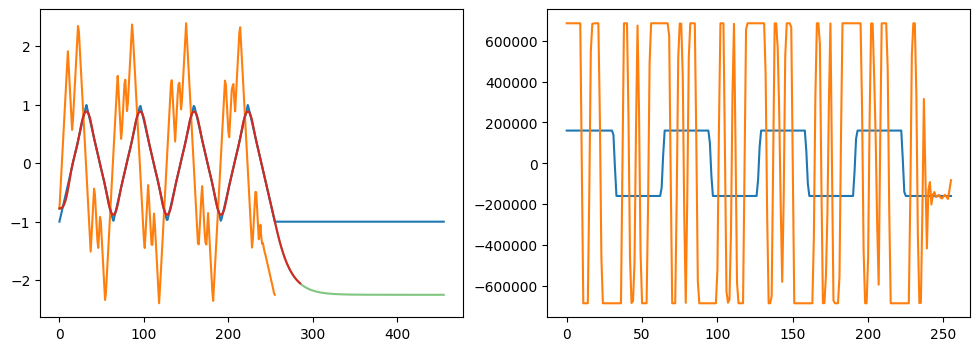

In [98]:
from pytrans.filter import pad_waveform
pad2 = 200


dt = trap_filter.dt

v0 = pad_waveform(voltage0, pad_after=pad2)
vfilt = filter_transform.transform(waveform0.value, pad_after=pad2)

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 4))
ax.plot(v0)
ax.plot(waveform0.value)
ax.plot(vfilt, alpha=0.6)
ax.plot(waveform_filtered.value)

dv = np.gradient(voltage0, dt, axis=0)
dw = np.gradient(waveform0.value, dt, axis=0)

ax1.plot(dv)
ax1.plot(dw)

# ax.set_xlim(200, 300)


In [89]:
(vfilt - v0)[-20:, 0].mean()

-0.0010897478931229387

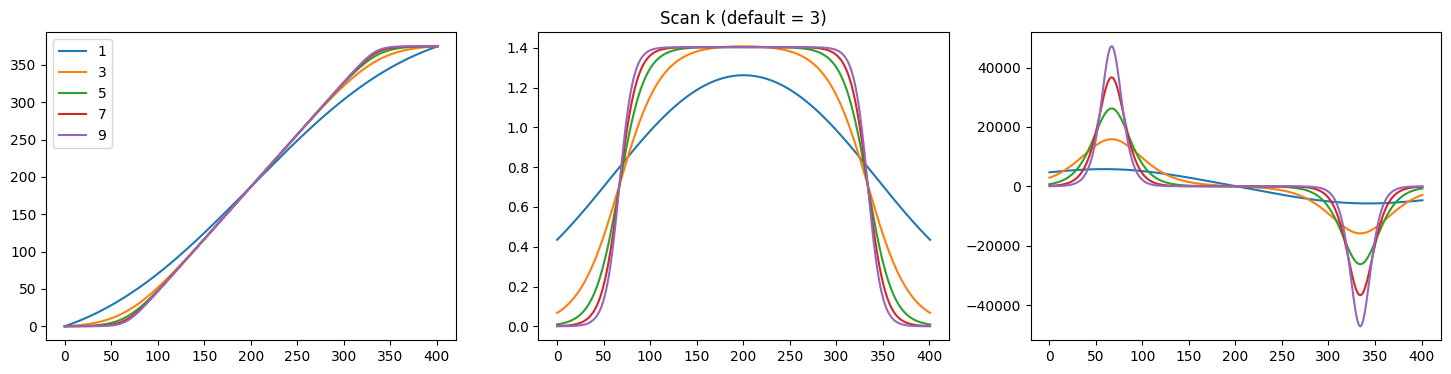

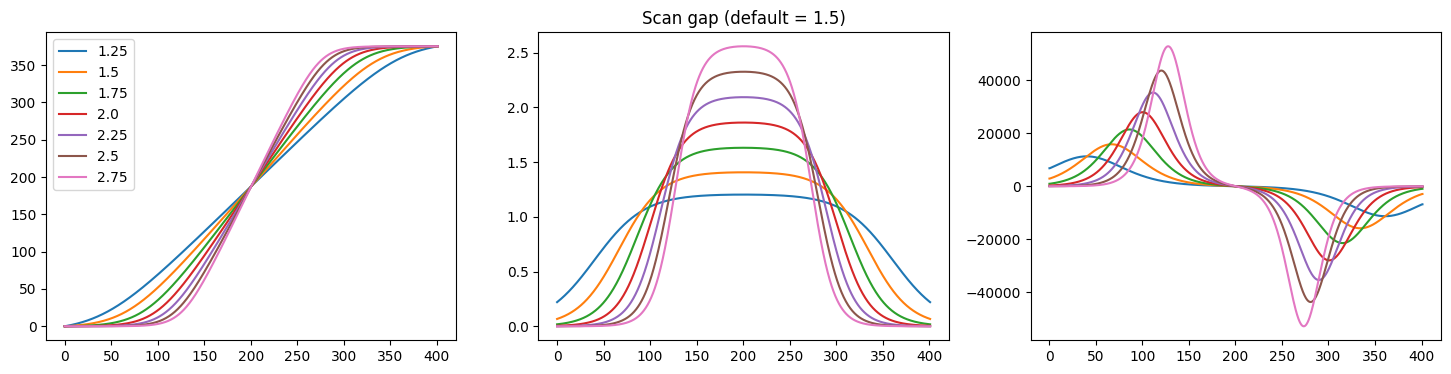

In [144]:
from pytrans.functions import zpspace

x0 = 375e-6
dt = 392e-9
t = np.arange(256 * 4) * dt

fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(18, 4))
for k in range(1, 10, 2):
    x = zpspace(0, x0, len(t), k=k, gap=1.5)
    v = np.gradient(x, t, edge_order=2)
    a = np.gradient(v, t)
    ax.plot(t * 1e6, x * 1e6, label=k)
    ax1.plot(t * 1e6, v)
    ax2.plot(t * 1e6, a)
ax1.set_title('Scan k (default = 3)')
ax.legend()

fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(18, 4))
for gap in np.arange(1.25, 3, 0.25):
    x = zpspace(0, x0, len(t), k=3, gap=gap)
    v = np.gradient(x, t, edge_order=2)
    a = np.gradient(v, t)
    ax.plot(t * 1e6, x * 1e6, label=gap)
    ax1.plot(t * 1e6, v)
    ax2.plot(t * 1e6, a)
ax1.set_title('Scan gap (default = 1.5)')
ax.legend()
